In [ ]:
FILEID = "1eSRyYy8Z2gLrcU4V32_3ZUUofdPzBlPI"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O SurfaceLaplacian.py && rm -rf /tmp/cookies.txt > /dev/null

--2021-06-01 13:59:35--  https://docs.google.com/uc?export=download&confirm=UZGG&id=1eSRyYy8Z2gLrcU4V32_3ZUUofdPzBlPI
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.113, 74.125.142.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-1g-docs.googleusercontent.com/docs/securesc/83lf3m8o833eqv1n9pms55dp7v15cjmf/mdq37fp4niomjvkunu8ekjuvnou1kecd/1622555925000/09711457892284675029/09349609861958638012Z/1eSRyYy8Z2gLrcU4V32_3ZUUofdPzBlPI?e=download [following]
--2021-06-01 13:59:35--  https://doc-10-1g-docs.googleusercontent.com/docs/securesc/83lf3m8o833eqv1n9pms55dp7v15cjmf/mdq37fp4niomjvkunu8ekjuvnou1kecd/1622555925000/09711457892284675029/09349609861958638012Z/1eSRyYy8Z2gLrcU4V32_3ZUUofdPzBlPI?e=download
Resolving doc-10-1g-docs.googleusercontent.com (doc-10-1g-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

In [ ]:
# SurfaceLaplacian()

In [ ]:
# Libreria
!pip install mne
import mne
from mne.connectivity import spectral_connectivity
from mne.viz import plot_sensors_connectivity 
from google.colab import drive
from scipy.io import loadmat
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pickle
from ipywidgets import interact_manual
from ipywidgets import interact
import csv
import os
import math as m
import matplotlib.mlab as mlab
from scipy.io import savemat
# drive.mount('/content/gdrive/')

In [ ]:
load_path = '/content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/'
data = mne.io.read_raw_edf(load_path+f"sub-01/eeg/sub-01_task-run1_eeg.edf")
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-49-6994e6506085>:2: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-01/eeg/sub-01_task-run1_eeg.edf")


In [ ]:
channels

['FP1',
 'FP2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'T3',
 'C3',
 'Cz',
 'C4',
 'T4',
 'T5',
 'P3',
 'Pz',
 'P4',
 'T6',
 'O1',
 'O2']

In [ ]:
# import json
# with open(load_path+f"sub-01/eeg/sub-01_task-run1_events.json") as f:
#   events = json.load(f)
from scipy import signal

In [ ]:
# load events in run
tsv_file = open(load_path+f"sub-01/eeg/sub-01_task-run1_events.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")
events = list()
for row in read_tsv:
  events.append(row)
tsv_file.close()

In [ ]:
events

[['onset', 'duration', 'trial_type']]

# funciones para filtrar la señal

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
## tempo-based BCMI data
load_path = '/content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/'
SS= list(np.arange(1,2))
runs = list(np.arange(2,10))
# Sampling frequency
fs  =  data.info['sfreq'] 
# Sample rate and desired cutoff frequencies (in Hz).
lowcut   = 1.0
highcut  = 100.0
orden_filtro = 5
N_ritmos = 7

for s in SS:
  #load data
  Database = list()
  y = list()
  if s < 10:

    for run in runs:
      tsv_file = open(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_events.tsv")
      read_tsv = csv.reader(tsv_file, delimiter="\t")
      events = list()
      for row in read_tsv:
        events.append(row)
      tsv_file.close()
      data_t = list()
      if len(events) > 1:
        data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")
        raw_data = data.get_data()
        for eve in range(1,len(events)):
          # database
          data_t.append(raw_data[:,m.floor(float(events[eve][0])*fs):m.floor((float(events[eve][0])+float(events[eve][1]))*fs)])
          # labels
          y.append(int(events[eve][2]))
      Database.append(np.concatenate(data_t,axis=1))

  else:

    for run in runs:
      tsv_file = open(load_path+f"sub-"+str(s)+"/eeg/sub-"+str(s)+"_task-run"+str(run)+"_events.tsv")
      read_tsv = csv.reader(tsv_file, delimiter="\t")
      events = list()
      for row in read_tsv:
        events.append(row)
      tsv_file.close()
      data_t = list()
      if len(events) > 1:
        data = mne.io.read_raw_edf(load_path+f"sub-"+str(s)+"/eeg/sub-"+str(s)+"_task-run"+str(run)+"_eeg.edf")
        raw_data = data.get_data()
        for eve in range(1,len(events)):
          # database
          data_t.append(raw_data[:,m.floor(float(events[eve][0])*fs):m.floor((float(events[eve][0])+float(events[eve][1]))*fs)])
          # labels
          y.append(int(events[eve][2]))
      Database.append(np.concatenate(data_t,axis=1))
  
  data_eeg = np.concatenate(Database,axis=1)
  # data listening
  ax_1,ax_2 = list(),list()
  for cl in range(1,2): #list(np.unique(y)):
    for i in range(len(y)):
      if y[i] == cl:
        ax_1.append(data_eeg[:,m.floor(4*fs+(20*i*fs)):m.floor(20*fs+(20*i*fs))])
      # else:
        ax_2.append(data_eeg[:,m.floor(4*fs+(20*i*fs)):m.floor(20*fs+(20*i*fs))])

  # data rest
  ax_1r,ax_2r = list(),list()
  for cl in range(1,2): #list(np.unique(y)):
    for i in range(len(y)):
      if y[i] == cl:
        ax_1r.append(data_eeg[:,m.floor(0*fs+(20*i*fs)):m.floor(4*fs+(20*i*fs))])
      # else:
        ax_2r.append(data_eeg[:,m.floor(0*fs+(20*i*fs)):m.floor(4*fs+(20*i*fs))])
        
  # PSD en las tareas
  data_x_cl1 = np.concatenate(ax_1,axis=1)
  PSD_cl1 = np.zeros((19,513))
  for channel in range(19):
    y = butter_bandpass_filter(data_x_cl1[channel,:], lowcut, highcut, fs, order=orden_filtro)
    # PSD
    freqs, PSD_cl1[channel,:] = signal.welch(y,fs=fs,nperseg=1024)

  data_x_cl2 = np.concatenate(ax_2,axis=1)
  PSD_cl2 = np.zeros((19,513))
  for channel in range(19):
    y = butter_bandpass_filter(data_x_cl2[channel,:], lowcut, highcut, fs, order=orden_filtro)
    # PSD
    freqs, PSD_cl2[channel,:] = signal.welch(y,fs=fs,nperseg=1024)

  # PSD en rest
  data_x_cl1r = np.concatenate(ax_1r,axis=1)
  PSD_cl1r = np.zeros((19,513))
  for channel in range(19):
    y = butter_bandpass_filter(data_x_cl1r[channel,:], lowcut, highcut, fs, order=orden_filtro)
    # PSD
    freqs, PSD_cl1r[channel,:] = signal.welch(y,fs=fs,nperseg=1024)

  data_x_cl2r = np.concatenate(ax_2r,axis=1)
  PSD_cl2r = np.zeros((19,513))
  
  for channel in range(19):
    y = butter_bandpass_filter(data_x_cl2r[channel,:], lowcut, highcut, fs, order=orden_filtro)
    # PSD
    freqs, PSD_cl2r[channel,:] = signal.welch(y,fs=fs,nperseg=1024)

  # Frecuencias
  
  # PSD en los ritmos listening
  PSD_CL1_ryt = list()
  PSD_CL2_ryt = list()
  for cl in range(1,3):
    for ryt in range(N_ritmos):
      if cl == 1:
        PSD_CL1_ryt.append(PSD_cl1[:,frecuencias[ryt][0]:frecuencias[ryt][1]])
      else:
        PSD_CL2_ryt.append(PSD_cl2[:,frecuencias[ryt][0]:frecuencias[ryt][1]])

  # PSD en los ritmos rest
  PSD_CL1_rytr = list()
  PSD_CL2_rytr = list()
  for cl in range(1,3):
    for ryt in range(N_ritmos):
      if cl == 1:
        PSD_CL1_rytr.append(PSD_cl1r[:,frecuencias[ryt][0]:frecuencias[ryt][1]])
      else:
        PSD_CL2_rytr.append(PSD_cl2r[:,frecuencias[ryt][0]:frecuencias[ryt][1]])

  # plt.figure(figsize=(5, 4))
  # plt.semilogx(freqs, psd)
  # plt.title('PSD: power spectral density')
  # plt.xlabel('Frequency')
  # plt.ylabel('Power')
  # plt.grid(True)
  # PSD rest

  savemat('/content/drive/MyDrive/BrainScore_2019/Pruebas2020/PSD'+str(s)+'.mat', {'PSD_CL1_rytr': PSD_CL1_rytr, 'PSD_CL2_rytr':PSD_CL2_rytr, 'PSD_CL1_ryt': PSD_CL1_ryt,'PSD_CL2_ryt':PSD_CL2_ryt})


Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")
<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")


Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run4_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run5_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")
<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")


Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run6_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run7_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")
<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")


Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run8_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/Shareddrives/GCPDS/databases/Tempo-based BCMI/sub-01/eeg/sub-01_task-run9_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")
<ipython-input-57-a028f7afa255>:29: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(load_path+f"sub-0"+str(s)+"/eeg/sub-0"+str(s)+"_task-run"+str(run)+"_eeg.edf")


In [ ]:
# Frecuencias
frecuencias = [[np.argmin(abs(freqs-1)),np.argmin(abs(freqs-4))],
            [np.argmin(abs(freqs-4)),np.argmin(abs(freqs-8))],
            [np.argmin(abs(freqs-8)),np.argmin(abs(freqs-12))],
            [np.argmin(abs(freqs-12)),np.argmin(abs(freqs-20))],
            [np.argmin(abs(freqs-20)),np.argmin(abs(freqs-30))],
            [np.argmin(abs(freqs-30)),np.argmin(abs(freqs-45))],
            [np.argmin(abs(freqs-55)),np.argmin(abs(freqs-95))]]
frecuencias

[[1, 4], [4, 8], [8, 12], [12, 20], [20, 31], [31, 46], [56, 97]]

In [ ]:
freqs

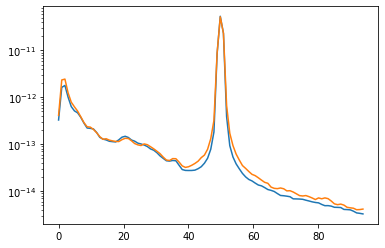

In [ ]:
plt.semilogy(freqs[0:97],PSD_cl1[9,0:97])
plt.semilogy(freqs[0:97],PSD_cl1r[9,0:97])

In [ ]:
data_x_cl1.shape
# data_x_cl1 = np.concatenate(ax_1,axis=1)
# np.concatenate(ax_1,axis=1).shape
# freqs, psd = signal.welch(np.concatenate(ax_1,axis=1))

(19, 2272000)

In [ ]:
data_eeg[:,m.floor(4*fs*(i+1)):m.floor(20*fs*(i+1))]

20000

In [ ]:
data_eeg = np.concatenate(Database,axis=1)

In [ ]:
data.to_data_frame().time

0              0
1              1
2              2
3              3
4              4
           ...  
390995    390995
390996    390996
390997    390997
390998    390998
390999    390999
Name: time, Length: 391000, dtype: int64

Effective window size : 2.048 (s)


<ipython-input-95-cfd892e49e99>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd()


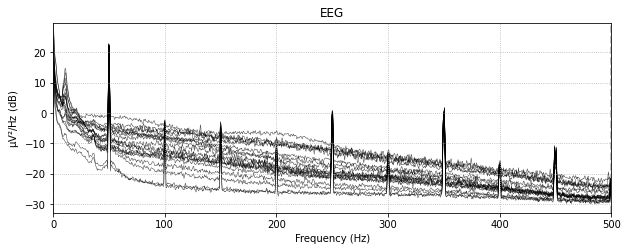

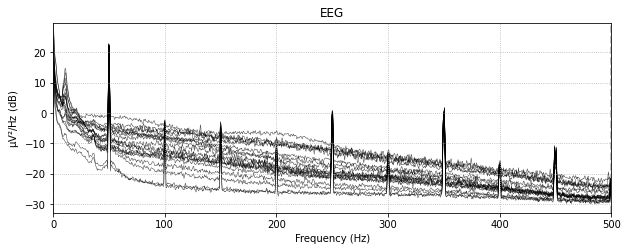

In [ ]:
data.plot_psd()

In [ ]:
events

[['onset', 'duration', 'trial_type'],
 ['16.359', '20', '2'],
 ['37.023', '20', '2'],
 ['57.496', '20', '2'],
 ['78.035', '20', '2'],
 ['99.502', '20', '1'],
 ['120.394', '20', '1'],
 ['140.521', '20', '1'],
 ['161.863', '20', '2'],
 ['182.055', '20', '2'],
 ['203.599', '20', '1'],
 ['223.875', '20', '1'],
 ['245.493', '20', '1'],
 ['266.136', '20', '1'],
 ['287.384', '20', '1'],
 ['309.156', '20', '1'],
 ['330.089', '20', '2'],
 ['350.232', '20', '2'],
 ['370.607', '20', '2']]

In [ ]:
#

# Conectivity in coherence

In [ ]:

Method = 'imcoh'     # Método utilizado.
sfreq  =  data.info['sfreq']         # Frecuencia de muestreo de la base de datos.
tmin, tmax, = 0.,0.8
cwt_freqs = np.arange(2,40, 2) 
cwt_n_cycles = cwt_freqs/ 5
# path_figs =  '/content/gdrive/Shareddrives/GCPDS/users/brainscore2/Códigos/Conectividad/datos_music_data_base/coh_ima_figs'
# path_datos = '/content/gdrive/Shareddrives/GCPDS/users/brainscore2/Códigos/Conectividad/datos_music_data_base/coherencia_imaginaria_datos'

for s in range(1):
  S_ERP = loadmat(load_path + f"P"+str(SS[s])+"_BCMI_frontHN_2017.mat")
  print('sujeto: ', SS[s])
  data = S_ERP['music'][0][0][0]
  data = np.transpose(data, (2,1,0)) # transponer en trials x canales x tiempo
  classes=np.array(S_ERP['music'][0][0][1])
  con_classes = []
  for clase in [50, 100, 150, 200]:
    # print('clase: tempo ', clase, 'beats per m')
    data_target= data[np.where(classes==clase)[SS[s]]][:,Num_channels,:] #50, 100, 150, 200
    # print('epochs dim', data_target.shape)
    ###cálculo de la conectividad.
    con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
      data_target, method=Method, mode='cwt_morlet', sfreq=sfreq, #fmin=4, fmax=40,
      faverage=False, tmin=tmin, tmax=tmax, mt_adaptive=False, #n_jobs=-1,
      cwt_freqs=cwt_freqs, cwt_n_cycles= cwt_n_cycles, verbose=0)
    con_classes.append(con)
    # print('iCOH shape: ', con.shape)

    #### figuras  

    # for time in [250, 300, 350, 400]:
      # plot_con =  np.mean(con[:,:,[0,1,2],time], axis= 2)

      # fig, ax = plt.subplots(figsize=(8,5))
      # im = ax.imshow(plot_con+ plot_con.T)
      # fig.colorbar(im, ax=ax)

      # We want to show all ticks...
      # ch_names = cha_names[pos_chan]

      # ax.set_xticks(np.arange(len(ch_names)))
      # ax.set_yticks(np.arange(len(ch_names)))
      # # ... and label them with the respective list entries
      # ax.set_xticklabels(ch_names)
      # ax.set_yticklabels(ch_names)

      # ax.set_title("Conectividad Motor-Auditory iCOH sujeto "+str(SS[s])+"classe_"+str(clase)+" en "+ str(time)+ "ms")
      # fig.tight_layout()
      # plt.savefig(path_figs+ "/giga19_iCOH_sbj"+str(SS[s])+"classe_"+str(clase)+"_time"+str(time/1000)+".jpg")
      # plt.show()

  #### save 
  icoh = { 'iCOH': con_classes,
         'freqs': freqs,
         'times': times,      
  }
  
  # with open( path_datos +'/music_Motor_Auditory_iCOH'+str(SS[s])+'.p','wb') as handle:
  #               pickle.dump(icoh ,handle)   
